# Exploratory Data Analysis - Raw Dataset

Questo notebook esegue un'analisi esplorativa completa del dataset raw per il progetto StiMatrix.

## Obiettivi dell'analisi:
1. Caricamento configurazione e dati
2. Overview del dataset (shape, dtypes, memoria, head)
3. Analisi missingness e cardinalità categoriche
4. Distribuzione del target `AI_Prezzo_Ridistribuito`
5. Summary per gruppi (`AI_ZonaOmi`, `AI_IdCategoriaCatastale`)
6. Correlazioni con il target
7. Check geospaziale rapido


## 1. Setup e caricamento dati


In [1]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurazione matplotlib per grafici più leggibili
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Setup completato!")


Setup completato!


In [2]:
# Caricamento configurazione
def load_config(config_path='../config/config.yaml'):
    """Carica il file di configurazione YAML"""
    with open(config_path, 'r', encoding='utf-8') as f:
        return yaml.safe_load(f)

# Caricamento dataset raw
def load_raw_data(config):
    """Carica il dataset raw usando i path dalla configurazione"""
    raw_path = Path('../data/raw') / config['paths']['raw_filename']
    print(f"Caricamento dati da: {raw_path}")
    if not raw_path.exists():
        raise FileNotFoundError(f"File non trovato: {raw_path}")
    return pd.read_parquet(raw_path)

# Esegui caricamento
config = load_config()
df_raw = load_raw_data(config)

print(f"✅ Configurazione caricata da: config/config.yaml")
print(f"✅ Dataset caricato: {df_raw.shape[0]:,} righe × {df_raw.shape[1]} colonne")


Caricamento dati da: ../data/raw/raw.parquet
✅ Configurazione caricata da: config/config.yaml
✅ Dataset caricato: 4,226 righe × 256 colonne


In [3]:
# Loader robusto con espansione placeholder e ricerca percorsi
import itertools

PLACEHOLDER_RE = re.compile(r"\$\{([^}:]+)(?::-(.*?))?\}")


def _expand_placeholders(value: str) -> str:
    if not isinstance(value, str):
        return value

    def _repl(m):
        var = m.group(1)
        default = m.group(2)
        if default is not None:
            default = default.strip()
            # rimuovi eventuali apici singoli/doppi ai bordi
            if (default.startswith("'") and default.endswith("'")) or (
                default.startswith('"') and default.endswith('"')
            ):
                default = default[1:-1]
        return os.environ.get(var, default if default is not None else "")

    return PLACEHOLDER_RE.sub(_repl, value)


def load_config(config_path_candidates=("config/config.yaml", "../config/config.yaml")):
    """Carica la config YAML e espande i placeholder ${VAR:-default}."""
    for cfg_path in config_path_candidates:
        p = Path(cfg_path)
        if p.exists():
            with open(p, "r", encoding="utf-8") as f:
                cfg = yaml.safe_load(f)
            # Espandi solo i campi che usiamo
            if "paths" in cfg:
                for k in ("raw_data", "raw_filename"):
                    if k in cfg["paths"]:
                        cfg["paths"][k] = _expand_placeholders(cfg["paths"][k])
            print(f"Config caricata da: {p}")
            return cfg
    raise FileNotFoundError(
        f"Impossibile trovare config.yaml in: {config_path_candidates}")


def load_raw_data(config):
    """Carica il parquet raw provando vari percorsi candidati (root e notebooks)."""
    raw_dir = config["paths"]["raw_data"]
    raw_fn = config["paths"].get("raw_filename", "raw.parquet")

    candidates = []
    bases = [Path("."), Path("..")]
    # Se raw_dir è assoluto, consideralo anche senza base
    if Path(raw_dir).is_absolute():
        candidates.append(Path(raw_dir) / raw_fn)
    # Aggiungi combinazioni base/raw_dir/raw_fn
    candidates.extend((b / raw_dir / raw_fn) for b in bases)

    tried = []
    for cand in candidates:
        cand = cand.resolve()
        tried.append(str(cand))
        print(f"Provo: {cand}")
        if cand.exists():
            print(f"Carico: {cand}")
            return pd.read_parquet(cand)

    raise FileNotFoundError(
        "File raw non trovato. Tentati percorsi: \n - " + "\n - ".join(tried)
    )

# Ricarica usando il loader robusto
config = load_config()
df_raw = load_raw_data(config)
print(f"✅ Dataset caricato: {df_raw.shape[0]:,} righe × {df_raw.shape[1]} colonne")


Config caricata da: ../config/config.yaml
Provo: /workspace/notebooks/data/raw/raw.parquet
Provo: /workspace/data/raw/raw.parquet
Carico: /workspace/data/raw/raw.parquet
✅ Dataset caricato: 4,226 righe × 256 colonne


## 2. Overview del dataset


In [4]:
# Informazioni generali sul dataset
def dataset_overview(df):
    """Fornisce overview completo del dataset"""
    print("\n" + "="*60)
    print("OVERVIEW DATASET")
    print("="*60)
    print(f"\n📊 Dimensioni: {df.shape[0]:,} righe × {df.shape[1]} colonne")
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2
    print(f"💾 Memoria utilizzata: {memory_mb:.2f} MB")
    print(f"\n📋 Tipi di dati:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} colonne")
    print(f"\n🎯 Target identificato: {config['target']['column_candidates'][0]}")
    return dtype_counts

# Esegui overview
dtype_summary = dataset_overview(df_raw)



OVERVIEW DATASET

📊 Dimensioni: 4,226 righe × 256 colonne
💾 Memoria utilizzata: 31.37 MB

📋 Tipi di dati:
  float64: 148 colonne
  object: 61 colonne
  int64: 43 colonne
  bool: 4 colonne

🎯 Target identificato: AI_Prezzo_Ridistribuito


In [5]:
# Prime righe del dataset
print("\n🔍 Prime 5 righe del dataset:")
display(df_raw.head())

# Informazioni dettagliate sulle colonne
print("\n📝 Informazioni dettagliate sulle colonne:")
df_info = df_raw.dtypes.to_frame('Tipo')
df_info['Valori Non-Nulli'] = df_raw.count()
df_info['Valori Nulli'] = df_raw.isnull().sum()
df_info['% Completamento'] = (1 - df_raw.isnull().mean()) * 100
display(df_info.round(2))



🔍 Prime 5 righe del dataset:


,A_AnnoStipula,A_MeseStipula,A_Anno,A_Semestre,A_RegPart,A_IdConservatoria,A_IdTipologiaAtto,A_IdDecodificaAtto,A_TotaleImmobili,A_Numero,...,POI_gym_count,POI_park_count,POI_restaurant_count,POI_school_count,POI_gas_station_count,POI_transit_station_count,POI_supermarket_count,POI_university_count,InZTL,AI_Prezzo_Ridistribuito
0,2023,9,2023,20231,NaN,MN00,Pertinenze,Pertinenze,1,2438036,...,3,0,3,0,1,15,1,2,0,25000.000000
1,2021,9,2021,20211,8205.0,MN00,Residenziale,Residenziale singolo,2,1238404,...,0,1,1,2,0,10,0,0,0,26128.878282
2,2021,9,2021,20211,8205.0,MN00,Residenziale,Residenziale singolo,2,1238404,...,0,1,1,2,0,10,0,0,0,65871.121718
3,2023,7,2023,20222,NaN,MN00,Residenziale,Residenziale singolo,2,2361168,...,1,0,15,8,0,12,0,2,0,13423.836389
4,2023,7,2023,20222,NaN,MN00,Residenziale,Residenziale singolo,2,2361168,...,1,0,15,8,0,12,0,2,0,256576.163611



📝 Informazioni dettagliate sulle colonne:


,Tipo,Valori Non-Nulli,Valori Nulli,% Completamento
A_AnnoStipula,int64,4226,0,100.00
A_MeseStipula,int64,4226,0,100.00
A_Anno,int64,4226,0,100.00
A_Semestre,object,4226,0,100.00
A_RegPart,float64,2407,1819,56.96
...,...,...,...,...
POI_transit_station_count,int64,4226,0,100.00
POI_supermarket_count,int64,4226,0,100.00
POI_university_count,int64,4226,0,100.00
InZTL,int64,4226,0,100.00


## 3. Analisi Missingness e Cardinalità


In [6]:
# Analisi missingness
def analyze_missingness(df):
    """Analizza la missingness nel dataset"""
    print("\n" + "="*60)
    print("ANALISI MISSINGNESS")
    print("="*60)

    missing_stats = pd.DataFrame({
        'Totale_Null': df.isnull().sum(),
        'Percentuale_Null': (df.isnull().mean() * 100).round(2),
        'Tipo': df.dtypes
    })

    high_missing = missing_stats[missing_stats['Percentuale_Null'] > 50].sort_values('Percentuale_Null', ascending=False)

    print(f"\n⚠️  Colonne con >50% valori mancanti ({len(high_missing)} colonne):")
    if len(high_missing) > 0:
        display(high_missing)
    else:
        print("  Nessuna colonna con >50% valori mancanti")

    return missing_stats

# Analisi cardinalità categoriche
def analyze_categorical_cardinality(df):
    """Analizza la cardinalità delle colonne categoriche"""
    print("\n" + "="*60)
    print("ANALISI CARDINALITÀ CATEGORICHE")
    print("="*60)

    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(cat_cols) == 0:
        print("\n❌ Nessuna colonna categorica trovata")
        return pd.DataFrame()

    cardinality_stats = []
    for col in cat_cols:
        unique_vals = df[col].nunique()
        total_vals = len(df[col])
        cardinality_ratio = unique_vals / total_vals

        cardinality_stats.append({
            'Colonna': col,
            'Valori_Unici': unique_vals,
            'Totale_Valori': total_vals,
            'Ratio_Cardinalità': round(cardinality_ratio, 4),
            'Tipo_Cardinalità': 'Alta' if cardinality_ratio > 0.1 else 'Bassa' if cardinality_ratio < 0.01 else 'Media'
        })

    cardinality_df = pd.DataFrame(cardinality_stats).sort_values('Valori_Unici', ascending=False)

    print(f"\n📊 Colonne categoriche trovate: {len(cat_cols)}")
    print(f"\n🔝 Top 10 colonne per cardinalità:")
    display(cardinality_df.head(10))

    return cardinality_df

# Esegui analisi
missing_stats = analyze_missingness(df_raw)
cardinality_stats = analyze_categorical_cardinality(df_raw)

# Salva risultati su CSV
output_dir = Path(__file__).resolve().parent / 'eda_outputs' if '__file__' in globals() else Path.cwd() / 'eda_outputs'
output_dir.mkdir(parents=True, exist_ok=True)

missing_stats.to_csv(output_dir / 'missingness_analysis.csv')
cardinality_stats.to_csv(output_dir / 'categorical_cardinality.csv')

print(f"\n💾 Risultati salvati in {output_dir}/")



ANALISI MISSINGNESS

⚠️  Colonne con >50% valori mancanti (22 colonne):


,Totale_Null,Percentuale_Null,Tipo
AI_SezioneAmministrativa,4226,100.00,object
AI_VisuraParseMutazioniSoggettiveErrore,4223,99.93,object
AI_VisuraErrore,4221,99.88,object
OV_Id_scadente,3921,92.78,object
OV_IdTipologiaEdilizia_scadente,3921,92.78,object
OV_IdZona_scadente,3921,92.78,object
OV_ValoreMercatoSup_scadente,3921,92.78,object
OV_ValoreLocazioneMin_scadente,3921,92.78,float64
OV_ValoreMercatoMin_scadente,3921,92.78,float64
OV_Stato_scadente,3921,92.78,object



ANALISI CARDINALITÀ CATEGORICHE



📊 Colonne categoriche trovate: 61

🔝 Top 10 colonne per cardinalità:


,Colonna,Valori_Unici,Totale_Valori,Ratio_Cardinalità,Tipo_Cardinalità
7,AI_Id,4226,4226,1.0000,Alta
18,AI_Posizione,1963,4226,0.4645,Alta
4,A_Codice,1627,4226,0.3850,Alta
54,PC_Poligono,1474,4226,0.3488,Alta
59,PC_Centroide,1474,4226,0.3488,Alta
55,PC_PoligonoGeoJson,1474,4226,0.3488,Alta
57,PC_BoundingBox,1474,4226,0.3488,Alta
58,PC_Isodistanza,1474,4226,0.3488,Alta
60,PC_PuntoInterno,1474,4226,0.3488,Alta
56,PC_PoligonoMetrico,1474,4226,0.3488,Alta



💾 Risultati salvati in /workspace/notebooks/eda_outputs/


## 4. Analisi del Target


In [7]:
# Identifica il target
target_col = config['target']['column_candidates'][0]

if target_col not in df_raw.columns:
    print(f"❌ Target '{target_col}' non trovato nelle colonne!")
    print(f"Colonne disponibili: {list(df_raw.columns)}")
    raise ValueError(f"Target column '{target_col}' not found")

print(f"\n🎯 Analisi del target: {target_col}")
print(f"📊 Tipo: {df_raw[target_col].dtype}")
print(f"🔢 Valori non-nulli: {df_raw[target_col].count()}")
print(f"📈 Valori mancanti: {df_raw[target_col].isnull().sum()} ({df_raw[target_col].isnull().mean()*100:.2f}%)")



🎯 Analisi del target: AI_Prezzo_Ridistribuito
📊 Tipo: float64
🔢 Valori non-nulli: 4226
📈 Valori mancanti: 0 (0.00%)



ANALISI DISTRIBUZIONE TARGET: AI_Prezzo_Ridistribuito

📈 Statistiche descrittive:
  Conteggio: 4,226
  Media: €67,109.59
  Mediana: €48,335.85
  Std Dev: €80,551.56
  Min: €244.65
  Max: €1,483,525.92

🏷️  Fasce di prezzo (quantili):
  Q00-Q20: €245 - €15,572
  Q20-Q40: €15,572 - €35,455
  Q40-Q60: €35,455 - €61,169
  Q60-Q80: €61,169 - €99,312
  Q80-Q100: €99,312 - €1,483,526


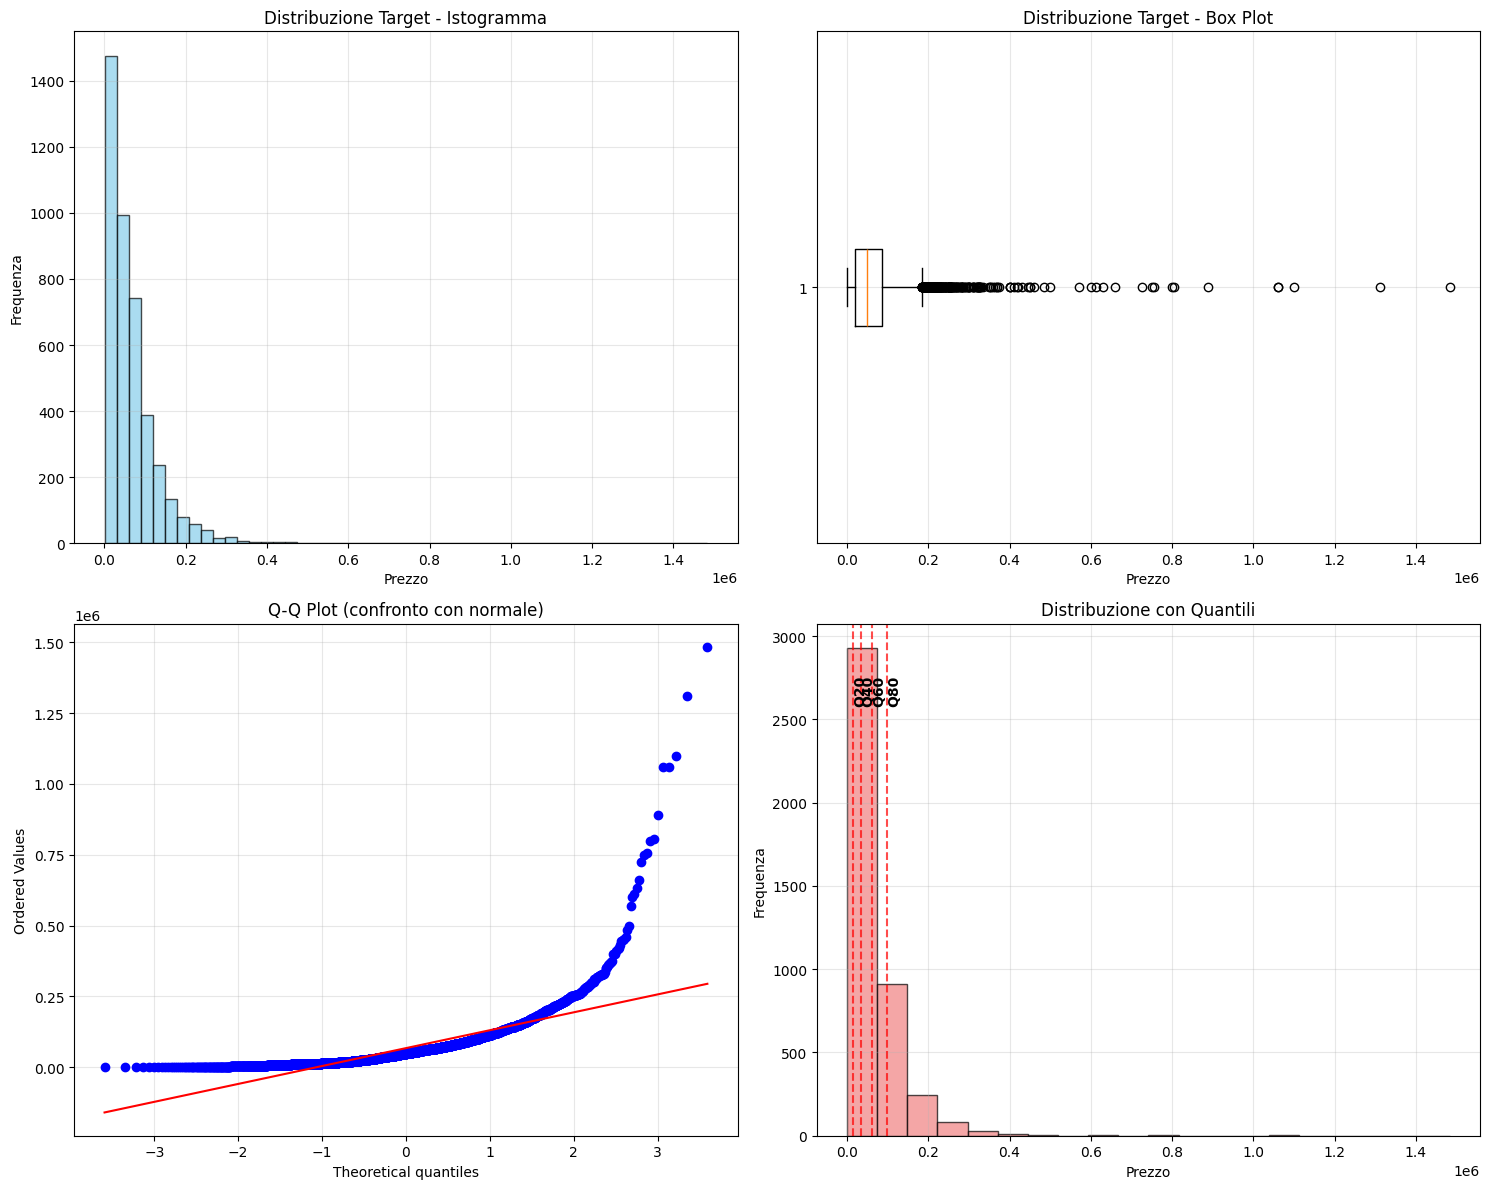

In [8]:
# Statistiche e fasce a quantili del target
from scipy import stats as scipy_stats


def analyze_target_distribution(df, target_col):
    """Analizza la distribuzione del target e crea fasce di prezzo"""
    print("\n" + "="*60)
    print(f"ANALISI DISTRIBUZIONE TARGET: {target_col}")
    print("="*60)

    target_data = df[target_col].dropna()
    stats = target_data.describe()

    print(f"\n📈 Statistiche descrittive:")
    print(f"  Conteggio: {stats['count']:,.0f}")
    print(f"  Media: €{stats['mean']:,.2f}")
    print(f"  Mediana: €{stats['50%']:,.2f}")
    print(f"  Std Dev: €{stats['std']:,.2f}")
    print(f"  Min: €{stats['min']:,.2f}")
    print(f"  Max: €{stats['max']:,.2f}")

    # Calcola fasce di prezzo a quantili
    quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    price_bands = target_data.quantile(quantiles)

    print(f"\n🏷️  Fasce di prezzo (quantili):")
    for i in range(len(quantiles)-1):
        q_low = quantiles[i]
        q_high = quantiles[i+1]
        price_low = price_bands.iloc[i]
        price_high = price_bands.iloc[i+1]
        print(f"  Q{int(q_low*100):02d}-Q{int(q_high*100):02d}: €{price_low:,.0f} - €{price_high:,.0f}")

    return stats, price_bands


def plot_target_distribution(df, target_col):
    """Crea grafici per la distribuzione del target"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    target_data = df[target_col].dropna()

    # 1. Istogramma
    axes[0,0].hist(target_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribuzione Target - Istogramma')
    axes[0,0].set_xlabel('Prezzo')
    axes[0,0].set_ylabel('Frequenza')
    axes[0,0].grid(True, alpha=0.3)

    # 2. Box plot
    axes[0,1].boxplot(target_data, vert=False)
    axes[0,1].set_title('Distribuzione Target - Box Plot')
    axes[0,1].set_xlabel('Prezzo')
    axes[0,1].grid(True, alpha=0.3)

    # 3. QQ Plot
    sample_size = min(5000, len(target_data))
    sample_data = target_data.sample(n=sample_size, random_state=42)
    scipy_stats.probplot(sample_data, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (confronto con normale)')
    axes[1,0].grid(True, alpha=0.3)

    # 4. Quantili
    quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    axes[1,1].hist(target_data, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    for q in quantiles[1:-1]:
        price_q = target_data.quantile(q)
        axes[1,1].axvline(price_q, color='red', linestyle='--', alpha=0.7)
        axes[1,1].text(price_q, axes[1,1].get_ylim()[1]*0.9, f'Q{int(q*100)}',
                       rotation=90, verticalalignment='top', fontweight='bold')
    axes[1,1].set_title('Distribuzione con Quantili')
    axes[1,1].set_xlabel('Prezzo')
    axes[1,1].set_ylabel('Frequenza')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Esegui analisi target
target_stats, price_bands = analyze_target_distribution(df_raw, target_col)
plot_target_distribution(df_raw, target_col)


## 5. Summary per Gruppi


In [9]:
# Colonne di grouping dalla configurazione
group_cols = ['AI_ZonaOmi', 'AI_IdCategoriaCatastale']

# Verifica che le colonne esistano
missing_group_cols = [col for col in group_cols if col not in df_raw.columns]
if missing_group_cols:
    print(f"❌ Colonne di grouping mancanti: {missing_group_cols}")
    print(f"Colonne disponibili: {list(df_raw.columns)}")
else:
    print(f"✅ Colonne di grouping trovate: {group_cols}")


✅ Colonne di grouping trovate: ['AI_ZonaOmi', 'AI_IdCategoriaCatastale']


In [10]:
# Funzione per creare summary per gruppi
def create_group_summary(df, group_col, target_col):
    """Crea summary statistico per una colonna di grouping"""
    print(f"\n📊 Summary per gruppo: {group_col}")
    print("-" * 50)

    valid_data = df[[group_col, target_col]].dropna()
    if len(valid_data) == 0:
        print(f"❌ Nessun dato valido per {group_col}")
        return pd.DataFrame()

    group_stats = valid_data.groupby(group_col)[target_col].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)

    group_stats = group_stats.sort_values('count', ascending=False)
    group_stats['cv'] = (group_stats['std'] / group_stats['mean'] * 100).round(2)

    print(f"Gruppi trovati: {len(group_stats)}")
    print(f"\n🔝 Top 10 gruppi per dimensione:")
    display(group_stats.head(10))

    return group_stats

# Esegui summary per entrambi i gruppi
group_summaries = {}

for group_col in group_cols:
    if group_col in df_raw.columns:
        group_summary = create_group_summary(df_raw, group_col, target_col)
        group_summaries[group_col] = group_summary
        
        # Salva su CSV
        output_file = output_dir / f'group_summary_{group_col}.csv'
        group_summary.to_csv(output_file)
        print(f"💾 Salvato: {output_file}")
    else:
        print(f"⚠️  Colonna {group_col} non trovata, skip")



📊 Summary per gruppo: AI_ZonaOmi
--------------------------------------------------
Gruppi trovati: 13

🔝 Top 10 gruppi per dimensione:


,count,mean,median,std,min,max,cv
AI_ZonaOmi,,,,,,,
B1,1252,93594.07,65000.00,109655.36,1200.00,1483525.92,117.16
C4,809,54657.31,52200.00,46136.08,705.23,322540.22,84.41
D2,598,82479.64,56747.67,98325.81,270.18,1311003.46,119.21
D1,483,38208.02,26415.18,34954.00,1687.00,254750.98,91.48
D3,296,40986.36,28192.71,41763.69,1500.00,326163.87,101.90
C2,237,47663.99,42128.96,36558.50,244.65,181589.96,76.70
C5,206,50329.50,50000.00,36062.81,4000.00,327262.96,71.65
C3,132,45741.89,37282.00,38082.17,1169.94,202312.69,83.25
E3,59,86365.49,36537.00,79293.93,6462.79,274431.22,91.81


💾 Salvato: /workspace/notebooks/eda_outputs/group_summary_AI_ZonaOmi.csv

📊 Summary per gruppo: AI_IdCategoriaCatastale
--------------------------------------------------
Gruppi trovati: 9

🔝 Top 10 gruppi per dimensione:


,count,mean,median,std,min,max,cv
AI_IdCategoriaCatastale,,,,,,,
00275,1546,19528.16,15269.65,16062.61,270.18,168996.54,82.25
00020,1469,108437.67,86619.05,85276.42,5330.00,1483525.92,78.64
00030,911,67518.96,57936.68,58201.29,2966.03,1311003.46,86.20
00200,124,94698.85,53500.00,145470.16,2000.00,1060000.00,153.61
00100,80,147680.02,80500.00,189493.28,1200.00,1100000.00,128.31
00040,53,44382.08,39600.00,28344.93,8470.59,160000.00,63.87
00070,38,150574.66,144246.71,68818.26,43889.32,326163.87,45.70
00050,4,22358.22,21094.11,24591.93,244.65,47000.00,109.99
00010,1,889313.48,889313.48,NaN,889313.48,889313.48,NaN


💾 Salvato: /workspace/notebooks/eda_outputs/group_summary_AI_IdCategoriaCatastale.csv


## 6. Correlazioni col Target, Colonne Costanti e NA elevati


In [11]:
# Colonne numeriche

def get_numeric_columns(df, target_col):
    """Identifica colonne numeriche escludendo il target"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    print(f"\n🔢 Colonne numeriche identificate: {len(numeric_cols)}")
    return numeric_cols


def identify_constant_columns(df, numeric_cols):
    """Identifica colonne numeriche costanti"""
    constant_cols = [col for col in numeric_cols if df[col].nunique() <= 1]
    print(f"\n⚠️  Colonne costanti identificate: {len(constant_cols)}")
    if constant_cols:
        print("  Colonne:", constant_cols)
    return constant_cols


def compute_correlations(df, target_col, numeric_cols, threshold=0.1):
    """Calcola correlazioni con il target"""
    print("\n" + "="*60)
    print(f"ANALISI CORRELAZIONI CON {target_col}")
    print("="*60)

    corr_data = df[numeric_cols + [target_col]].dropna()
    if len(corr_data) == 0:
        print("❌ Nessun dato valido per correlazioni")
        return pd.DataFrame()

    correlations = corr_data.corr(numeric_only=True)[target_col].drop(target_col)

    corr_df = pd.DataFrame({
        'Colonna': correlations.index,
        'Correlazione': correlations.values,
        'Correlazione_Assoluta': np.abs(correlations.values)
    }).round(4).sort_values('Correlazione_Assoluta', ascending=False)

    significant_corr = corr_df[corr_df['Correlazione_Assoluta'] >= threshold]
    print(f"\n📈 Correlazioni significative (|r| >= {threshold}): {len(significant_corr)}")
    if len(significant_corr) > 0:
        display(significant_corr.head(15))

    print(f"\n📊 Statistiche correlazioni:")
    print(f"  Max correlazione positiva: {corr_df['Correlazione'].max():.4f}")
    print(f"  Max correlazione negativa: {corr_df['Correlazione'].min():.4f}")
    print(f"  Media correlazione assoluta: {corr_df['Correlazione_Assoluta'].mean():.4f}")

    return corr_df


# Colonne con NA elevati (> 50%)
def identify_high_na_columns(df, threshold=0.5):
    na_ratio = df.isna().mean()
    high_na_cols = na_ratio[na_ratio > threshold].index.tolist()
    print(f"\n⚠️  Colonne con NA > {int(threshold*100)}%: {len(high_na_cols)}")
    if high_na_cols:
        print("  Colonne:", high_na_cols[:30], ("..." if len(high_na_cols) > 30 else ""))
    return high_na_cols


# Esecuzione analisi
numeric_cols = get_numeric_columns(df_raw, target_col)
constant_cols = identify_constant_columns(df_raw, numeric_cols)
high_na_cols = identify_high_na_columns(df_raw, threshold=0.5)
correlation_results = compute_correlations(df_raw, target_col, [c for c in numeric_cols if c not in constant_cols])

# Salvataggi
if len(correlation_results) > 0:
    correlation_results.to_csv(output_dir / 'correlations_with_target.csv', index=False)
if constant_cols:
    pd.Series(constant_cols, name='constant_columns').to_csv(output_dir / 'constant_numeric_columns.csv', index=False)
if high_na_cols:
    pd.Series(high_na_cols, name='high_na_columns').to_csv(output_dir / 'high_na_columns.csv', index=False)

print(f"\n💾 Output correlazioni salvati in {output_dir}/")



🔢 Colonne numeriche identificate: 190

⚠️  Colonne costanti identificate: 8
  Colonne: ['ISC_CodReg', 'ISC_CodUts', 'ISC_ProCom', 'ISC_CodZic', 'OV_ValoreMercatoMin_scadente', 'OV_ValoreMercatoMax_scadente', 'OV_ValoreLocazioneMin_scadente', 'PC_PoligonoMetricoSrid']

⚠️  Colonne con NA > 50%: 22
  Colonne: ['AI_SezioneAmministrativa', 'AI_VisuraErrore', 'AI_VisuraParseMutazioniSoggettiveErrore', 'AI_SuperficieVisuraTotaleE', 'OV_Id_ottimo', 'OV_Id_scadente', 'OV_IdZona_ottimo', 'OV_IdZona_scadente', 'OV_IdTipologiaEdilizia_ottimo', 'OV_IdTipologiaEdilizia_scadente', 'OV_Stato_ottimo', 'OV_Stato_scadente', 'OV_ValoreMercatoMin_ottimo', 'OV_ValoreMercatoMin_scadente', 'OV_ValoreMercatoMax_ottimo', 'OV_ValoreMercatoMax_scadente', 'OV_ValoreMercatoSup_ottimo', 'OV_ValoreMercatoSup_scadente', 'OV_ValoreLocazioneMin_ottimo', 'OV_ValoreLocazioneMin_scadente', 'OV_ValoreLocazioneMax_ottimo', 'OV_ValoreLocazioneSup_ottimo'] 

ANALISI CORRELAZIONI CON AI_Prezzo_Ridistribuito

📈 Correlazioni si

,Colonna,Correlazione,Correlazione_Assoluta
18,AI_SuperficieVisuraTotale,0.6906,0.6906
22,AI_Superficie,0.6906,0.6906
20,AI_SuperficieVisuraTotaleAttuale,0.6856,0.6856
19,AI_SuperficieVisuraTotaleE,0.6824,0.6824
14,AI_Rendita,0.6791,0.6791
21,AI_SuperficieVisuraTotaleEAttuale,0.6763,0.6763
16,AI_SuperficieCalcolata,0.6288,0.6288
152,OV_ValoreMercatoMin_normale,0.2642,0.2642
119,II_ST22,-0.2614,0.2614
154,OV_ValoreMercatoMax_normale,0.2594,0.2594



📊 Statistiche correlazioni:
  Max correlazione positiva: 0.6906
  Max correlazione negativa: -0.2614
  Media correlazione assoluta: 0.1172

💾 Output correlazioni salvati in /workspace/notebooks/eda_outputs/


## 7. Check Geospaziale (WKT/GeoJSON e coordinate)


In [12]:
# Identifica colonne geospaziali candidate

def identify_geospatial_columns(df):
    """Identifica colonne che potrebbero contenere dati geospaziali (WKT/GeoJSON/coordinate)."""
    print("\n" + "="*60)
    print("CHECK GEOSPAZIALE RAPIDO")
    print("="*60)

    candidates = []
    all_cols = df.columns.tolist()

    # Pattern di interesse
    geo_patterns = [
        # WKT/GeoJSON
        'wkt', 'geometry', 'geom', 'geojson', 'the_geom', 'shape', 'polygon', 'point', 'linestring',
        # Coordinate
        'lat', 'latitude', 'lon', 'lng', 'longitude', 'coord', 'x_', 'y_', 'easting', 'northing',
        # Generici
        'geo', 'spatial', 'location', 'posizione', 'indirizzo', 'address'
    ]

    for col in all_cols:
        col_l = col.lower()
        for pat in geo_patterns:
            if pat in col_l:
                sample_vals = df[col].dropna().head(3).tolist()
                candidates.append({
                    'Colonna': col,
                    'Tipo': str(df[col].dtype),
                    'Pattern': pat,
                    'NonNull_Count': int(df[col].count()),
                    'Esempi': sample_vals
                })
                break

    # Heuristics contenuto: prova a riconoscere WKT / GeoJSON testuali
    def looks_like_wkt(s):
        if not isinstance(s, str):
            return False
        s0 = s.strip().upper()
        return s0.startswith(('POINT', 'LINESTRING', 'POLYGON', 'MULTIPOLYGON', 'MULTILINESTRING', 'MULTIPOINT'))

    def looks_like_geojson(s):
        if not isinstance(s, (str, dict)):
            return False
        if isinstance(s, dict):
            return 'type' in s and 'coordinates' in s
        s0 = s.strip().lower()
        return s0.startswith('{') and '"type"' in s0 and '"coordinates"' in s0

    for col in all_cols:
        if df[col].dtype == 'object':
            sample = df[col].dropna().astype(str).head(5)
            if len(sample) > 0:
                if sample.map(looks_like_wkt).any():
                    candidates.append({'Colonna': col, 'Tipo': 'object', 'Pattern': 'WKT_content',
                                       'NonNull_Count': int(df[col].count()), 'Esempi': sample.head(3).tolist()})
                elif sample.map(looks_like_geojson).any():
                    candidates.append({'Colonna': col, 'Tipo': 'object', 'Pattern': 'GeoJSON_content',
                                       'NonNull_Count': int(df[col].count()), 'Esempi': sample.head(3).tolist()})

    if not candidates:
        print("\n❌ Nessuna colonna geospaziale candidata individuata")
        return pd.DataFrame()

    geo_df = pd.DataFrame(candidates).drop_duplicates(subset=['Colonna', 'Pattern'])
    print(f"\n🗺️  Colonne candidate geospaziali: {len(geo_df)}")
    display(geo_df)
    return geo_df

# Esegui check geospaziale
geo_cols = identify_geospatial_columns(df_raw)
if len(geo_cols) > 0:
    geo_cols.to_csv(output_dir / 'geospatial_columns_check.csv', index=False)
    print(f"\n💾 Check geospaziale salvato in {output_dir}/geospatial_columns_check.csv")



CHECK GEOSPAZIALE RAPIDO

🗺️  Colonne candidate geospaziali: 24


,Colonna,Tipo,Pattern,NonNull_Count,Esempi
0,AI_Latitudine,float64,lat,4226,"[45.1503481, 45.150455474853516, 45.1504554748..."
1,AI_Longitudine,float64,lon,4226,"[10.7645318, 10.770710945129395, 10.7707109451..."
2,AI_Posizione,object,posizione,4226,"[POINT (10.7645318 45.1503481), POINT (10.7707..."
3,AI_SuperficieCalcolata,float64,lat,4223,"[18.0, 21.0, 60.0]"
4,ISC_Geometry,object,geometry,4226,[MULTIPOLYGON (((10.767331549979215 45.1511532...
5,ISC_ShapeLeng,float64,shape,4226,"[3178.32180066, 651.399531498, 651.399531498]"
6,ISC_ShapeArea,float64,shape,4226,"[177693.4543, 16052.9653428, 16052.9653428]"
7,OV_ValoreMercatoMax_normale,float64,x_,4226,"[950.0, 1000.0, 900.0]"
8,OV_ValoreMercatoMax_ottimo,float64,x_,1425,"[1500.0, 3000.0, 3000.0]"
9,OV_ValoreMercatoMax_scadente,float64,x_,305,"[750.0, 750.0, 750.0]"



💾 Check geospaziale salvato in /workspace/notebooks/eda_outputs/geospatial_columns_check.csv
